Vision Transformers (ViT)

In [1]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, MultiHeadAttention
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

Check Image Corruption

In [2]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


In [9]:
def preprocess_image(image_path, size=(224, 224)):
    try:
        img = Image.open(image_path)
        
        # Quality enhancement
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)  # Increase sharpness
        
        # Noise reduction
        image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Consistency
        img = img.resize(size, Image.LANCZOS)

        # Normalization
        img_array = np.array(img) / 255.0
    
        # Convert back to image
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        
        return img
    except (UnidentifiedImageError, IOError) as e:
        print(f"Error processing image {image_path}: {e}")
        return None

input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

# Apply preprocessing and save to new directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img:
                preprocessed_img.save(os.path.join(output_category_path, image_name))


In [3]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [4]:
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=21, l2_rate=0.01):
    # Create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Add custom layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_rate))(x)

    # Construct the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = create_vgg16_model()

2024-07-23 18:32:54.982170: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-23 18:32:54.982219: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-23 18:32:54.982242: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-23 18:32:54.982577: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-23 18:32:54.982610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
import json
import os

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path
        # Create the file initially or clear existing file
        if not os.path.exists(file_path):
            with open(file_path, 'w') as f:
                json.dump({}, f)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'r+') as f:
            history = json.load(f)
            for key, value in logs.items():
                if key in history:
                    history[key].append(value)
                else:
                    history[key] = [value]
            f.seek(0)  # Go to the beginning of the file
            json.dump(history, f, indent=4)

In [6]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_VIT_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min',
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping, SaveHistoryCallback('models/VIT_history.json')],
)


Epoch 1/20


2024-07-23 18:33:02.577874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2267 - loss: 10.5195
Epoch 1: val_loss improved from inf to 7.95531, saving model to models/best_VIT_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.2276 - loss: 10.5103 - val_accuracy: 0.5771 - val_loss: 7.9553
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5499 - loss: 7.7246
Epoch 2: val_loss improved from 7.95531 to 6.67454, saving model to models/best_VIT_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.5501 - loss: 7.7226 - val_accuracy: 0.7438 - val_loss: 6.6745
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6196 - loss: 6.8498
Epoch 3: val_loss improved from 6.67454 to 5.97018, saving model to models/best_VIT_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.6198 - loss: 6.8482 - val_accuracy: 0.7667 - val_loss: 5.9702
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6951 - loss: 6.1369
Epoch 4: val_loss improved from

In [7]:
# Evaluate the model
model = tf.keras.models.load_model('models/best_VIT_model.keras')
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9496 - loss: 1.9558
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8686 - loss: 2.1924
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8655 - loss: 2.2409
Train accuracy: 0.9471, Validation accuracy: 0.8624, Test accuracy: 0.8657


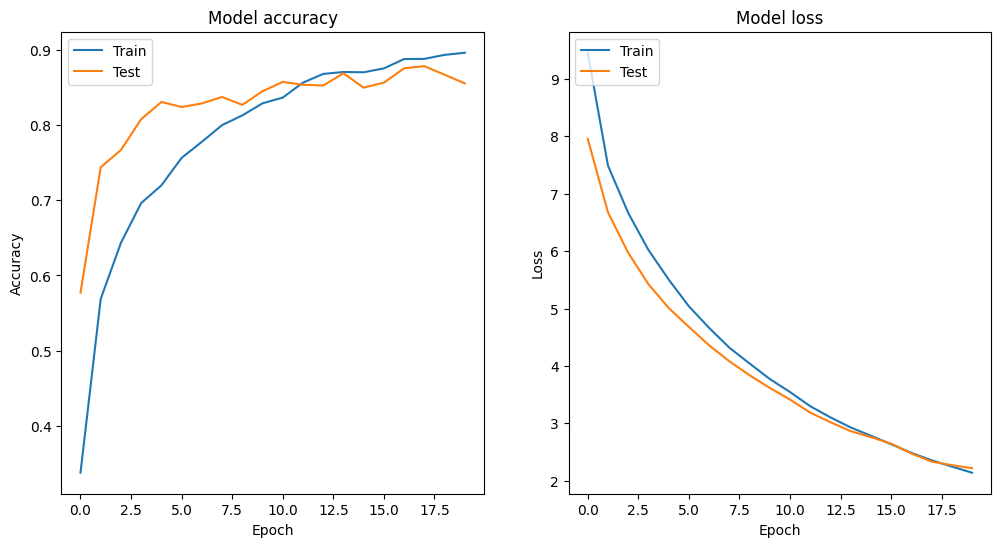

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step


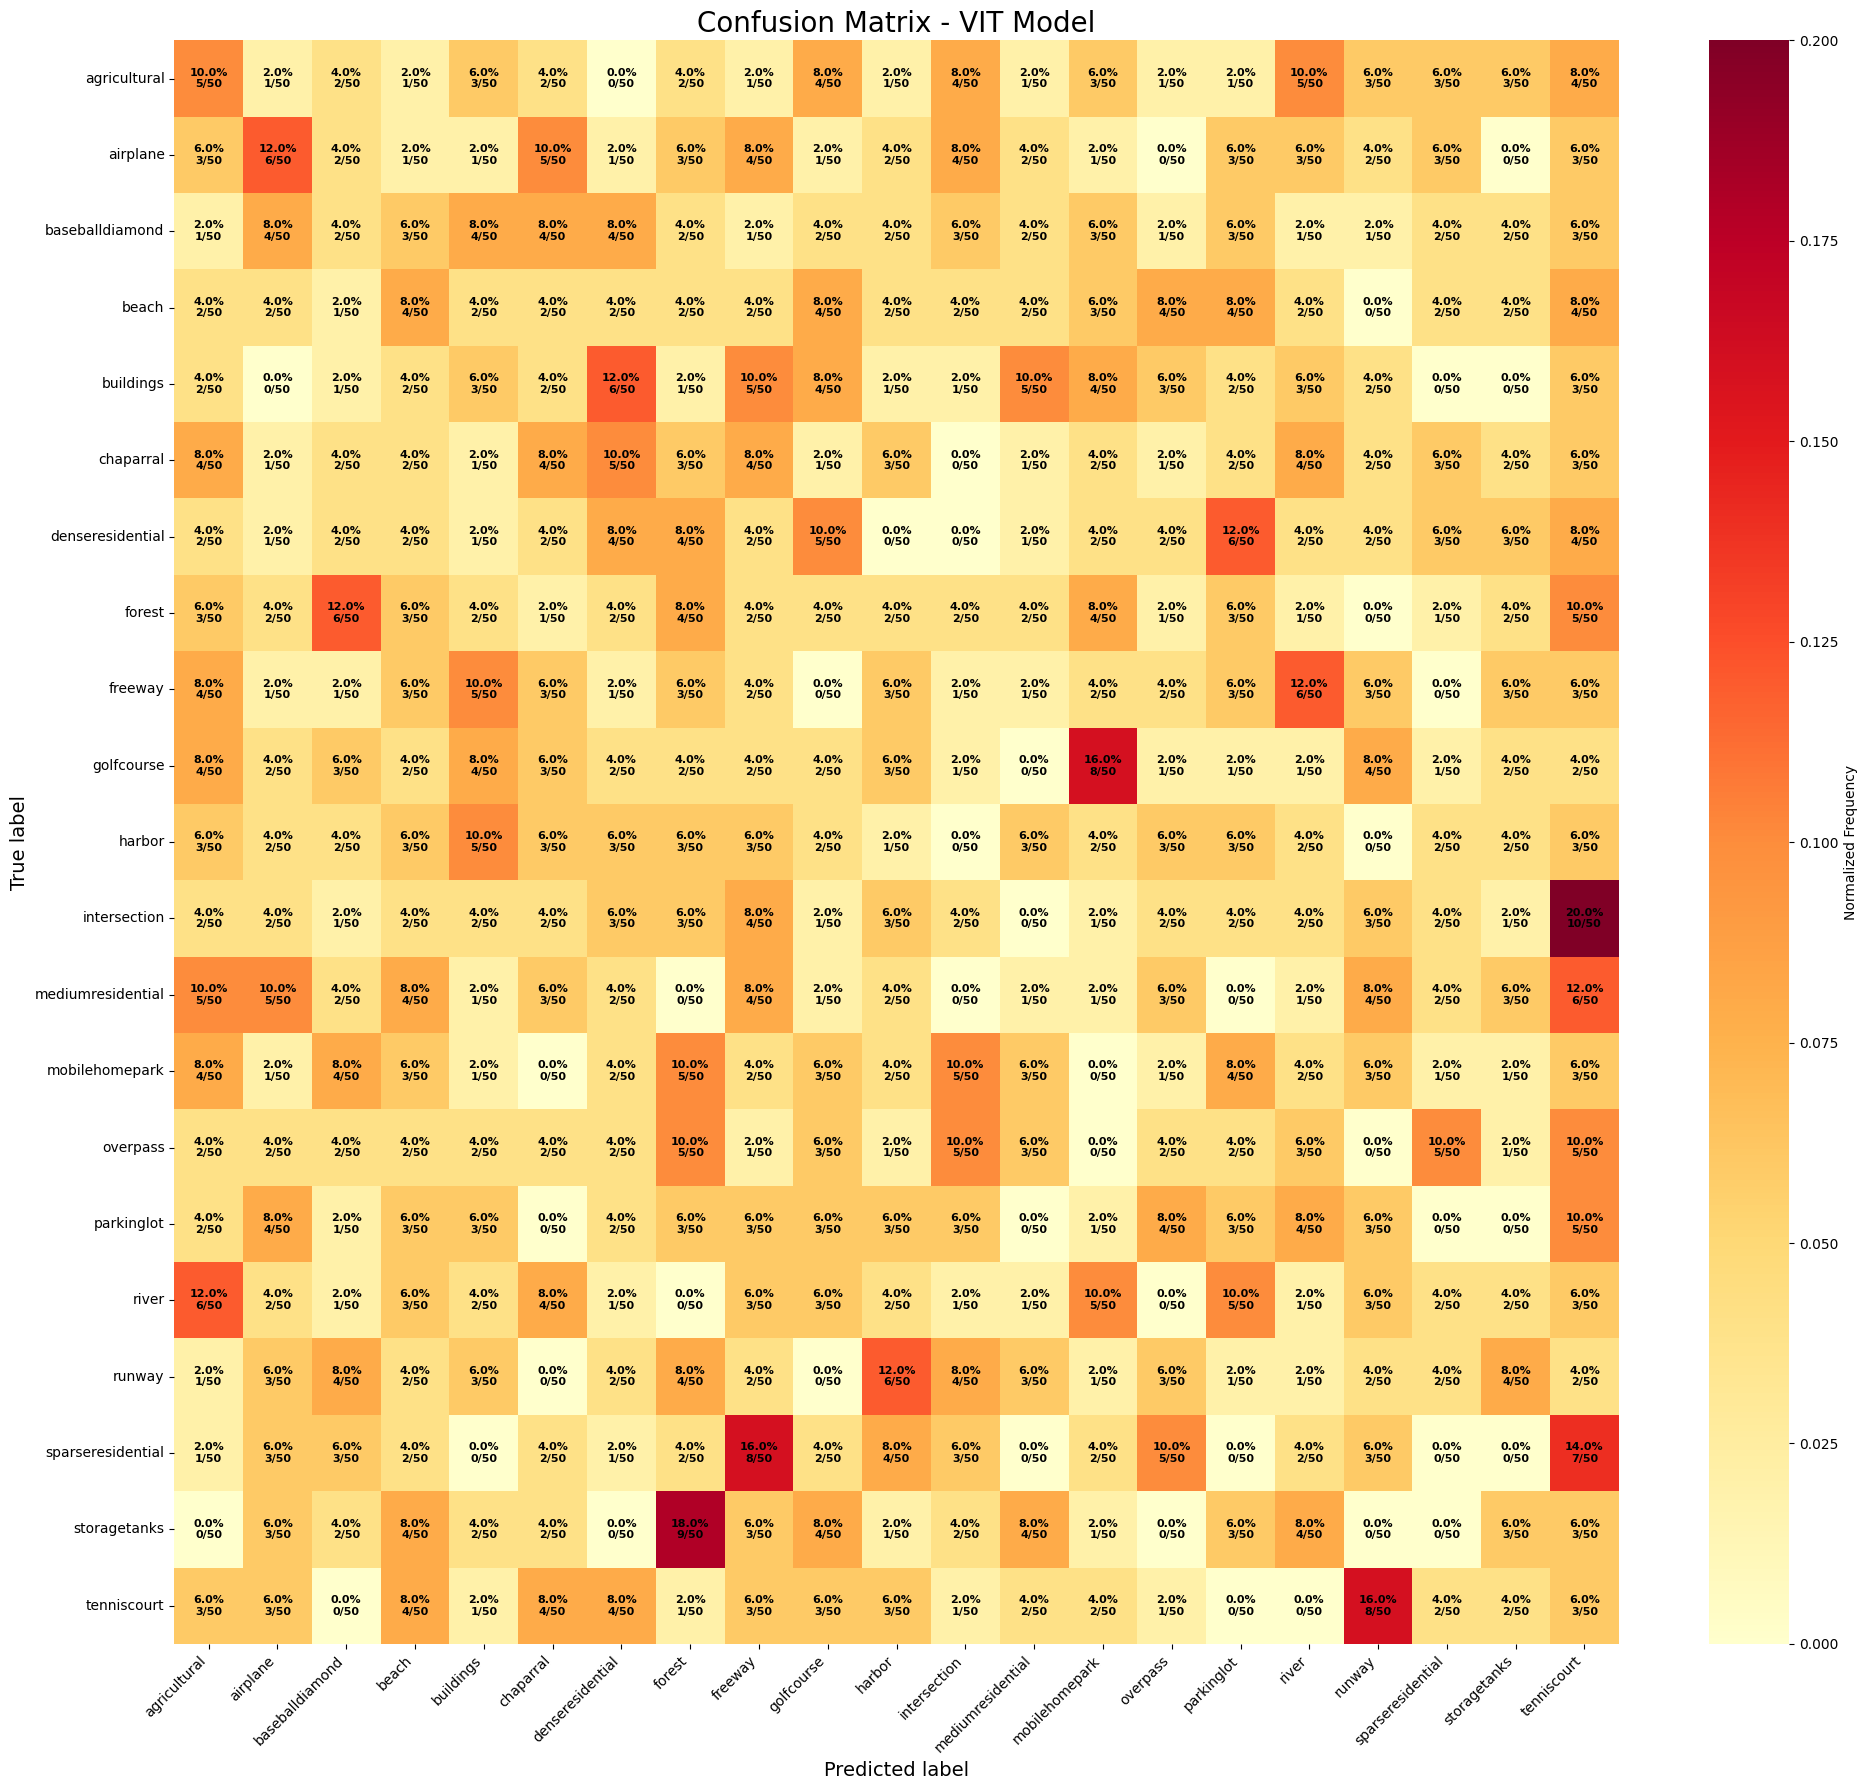

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model (assuming you've saved it during training)
model = load_model('models/best_VIT_model.keras')

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Normalized Frequency'})

# Customize the plot
plt.title('Confusion Matrix - VIT Model', fontsize=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add text annotations for percentages and absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm_normalized[i, j]:.1%}\n{cm[i, j]}/{cm[i, :].sum()}", 
                 ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white", 
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()